1. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

2. Повторить п.2, но используя уже не медиану, а max

3. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных методов получения эмбедингов пользователей: mean, median, max, по метрикам roc_auc, precision, recall, f_score

4. Сделать самостоятельные выводы и предположения о том, почему тот или иной способ оказался эффективнее остальных.

In [96]:
import re
import pymorphy2
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from razdel import tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from gensim.models import LdaModel
from gensim.test.utils import datapath
from gensim.corpora.dictionary import Dictionary

%matplotlib inline

In [97]:
stopword_ru = stopwords.words('russian')

morph = pymorphy2.MorphAnalyzer()

with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords

In [98]:
def clean_text(text):
    '''
    очистка текста
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}


def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords


def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [99]:
#считываем данные из файлов
news = pd.read_csv("articles.csv")
users = pd.read_csv("users_articles.csv")
target = pd.read_csv("users_churn.csv")

#### Векторизуем тексты и обучим LDA модель

In [100]:
#запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

In [101]:
#запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

In [102]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

#создаем корпус из списка текстов
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [103]:
#запускаем обучение LDA модели
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)

In [104]:
#записываем модель на диск
temp_file = datapath("model.lda")
lda.save(temp_file)

#### Создаем векторные представления пользователей

In [118]:
#считываем модель с диска
lda = LdaModel.load(temp_file)

In [119]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

In [120]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]

In [122]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [123]:
def get_user_embedding(user_articles_list, func=np.mean):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = func(user_vector, 0)
    return user_vector

func_list =[np.mean, np.median, np.max]

#### Обучим модель предсказания оттока клиентов на векторном представлении пользователей, используя разные фукции агрегации из списка функций func_list. Для каждой функци агрегации посчитаем метрики качества.  

Модель с агрегатной функцией mean
Confusion matrix, without normalization
[[1640  120]
 [  80  160]]


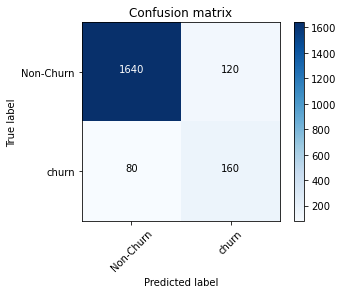

--------------------------------------------------
Модель с агрегатной функцией median
Confusion matrix, without normalization
[[1629  131]
 [  36  204]]


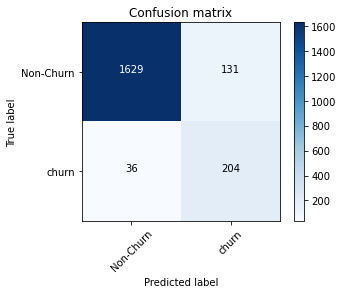

--------------------------------------------------
Модель с агрегатной функцией amax
Confusion matrix, without normalization
[[1695   65]
 [  64  176]]


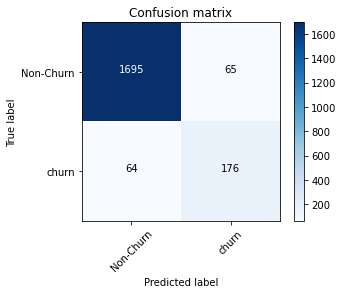

--------------------------------------------------


In [133]:
metrics = []
for Func in func_list:
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, func=Func), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]] 
    X = pd.merge(user_embeddings, target, 'left')
    #разделим данные на train/test
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                        X['churn'], random_state=21)
    logreg = LogisticRegression()
    #обучим 
    logreg.fit(X_train, y_train)

    #прогнозы для тестовой выборки
    preds = logreg.predict_proba(X_test)[:, 1]
    
    # Рассчитаем Precision, Recall, F_score
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    metrics.append([Func.__name__, thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)])

    #мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
    print(f'Модель с агрегатной функцией {Func.__name__}')
    font = {'size' : 10}
    plt.rc('font', **font)
    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(5, 4))
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'], title='Confusion matrix')
    plt.savefig("conf_matrix.png")

    plt.show()
    print('-'*50)

#### Сформируем таблицу, сравнивающую качество 3 разных методов

In [134]:
from prettytable import PrettyTable
mytable = PrettyTable()
# имена полей таблицы
mytable.field_names = ["function", "thresholds", "fscore", "precision", "recall", "roc_auc_score"]
# добавление данных по одной строке за раз
for i in range(3):
    mytable.add_row([elem for elem in metrics[i]])
# вывод таблицы 
print(mytable)

+----------+---------------------+--------------------+--------------------+--------------------+--------------------+
| function |      thresholds     |       fscore       |     precision      |       recall       |   roc_auc_score    |
+----------+---------------------+--------------------+--------------------+--------------------+--------------------+
|   mean   |  0.2558651836689734 | 0.6180422264875239 | 0.5729537366548043 | 0.6708333333333333 | 0.9192140151515152 |
|  median  | 0.24360518178956742 | 0.7118055555555556 | 0.6101190476190477 | 0.8541666666666666 | 0.9579048295454545 |
|   amax   |  0.3201107547619725 | 0.7344398340248964 | 0.731404958677686  |       0.7375       | 0.9605468750000001 |
+----------+---------------------+--------------------+--------------------+--------------------+--------------------+


Из сравнения агрегирующих функций видим, что использование функции max дает наилучшее предсказание оттока пользователей (т.е. AUC близкий к 1 и лучшие показатели precision и fscore). Это связано вероятно с тем, что max выделяет самую значимую для пользователя категорию статей и далее классификация пользователей производится на основе самой значимой категории. А функции mean и median усредняют категории статей (т.е. добавляют случайный шум к основной категории), что соответственно уменьшает метрики качества.